In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from cmcrameri import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle 
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# add columns to identify modern 'dead' glaciers
all_data_gdf['dead_ela_today'] = all_data_gdf['off_glacier_avg_product'].copy()
all_data_gdf['dead_aar_today'] = (all_data_gdf['aar_infill_avg_product']<0.1).astype(int)
all_data_gdf['dead_today'] = np.nanmax(all_data_gdf[['dead_ela_today', 'dead_aar_today']], axis=1).astype(int)

# add columns to identify glaciers dead with 100, 200 m ela rise
all_data_gdf['dead_100'] = (all_data_gdf['hyps_aar_100']<0.1).astype(int)
all_data_gdf['dead_200'] = (all_data_gdf['hyps_aar_200']<0.1).astype(int)

# column for dead glacier under cmip scenario
all_data_gdf['dead_cmip'] = (all_data_gdf['hyps_aar_cmip']<0.1).astype(int)

# simplify to single column
all_data_gdf['dead_color'] = np.nansum(all_data_gdf[['dead_today','dead_100','dead_200']], axis=1)
all_data_gdf['dead_color_cmip'] = np.nansum(all_data_gdf[['dead_today','dead_cmip']], axis=1)
print(all_data_gdf['dead_today'].sum(), all_data_gdf['dead_100'].sum(), all_data_gdf['dead_200'].sum(), all_data_gdf['dead_cmip'].sum())

1009 1587 2083 1944


In [5]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

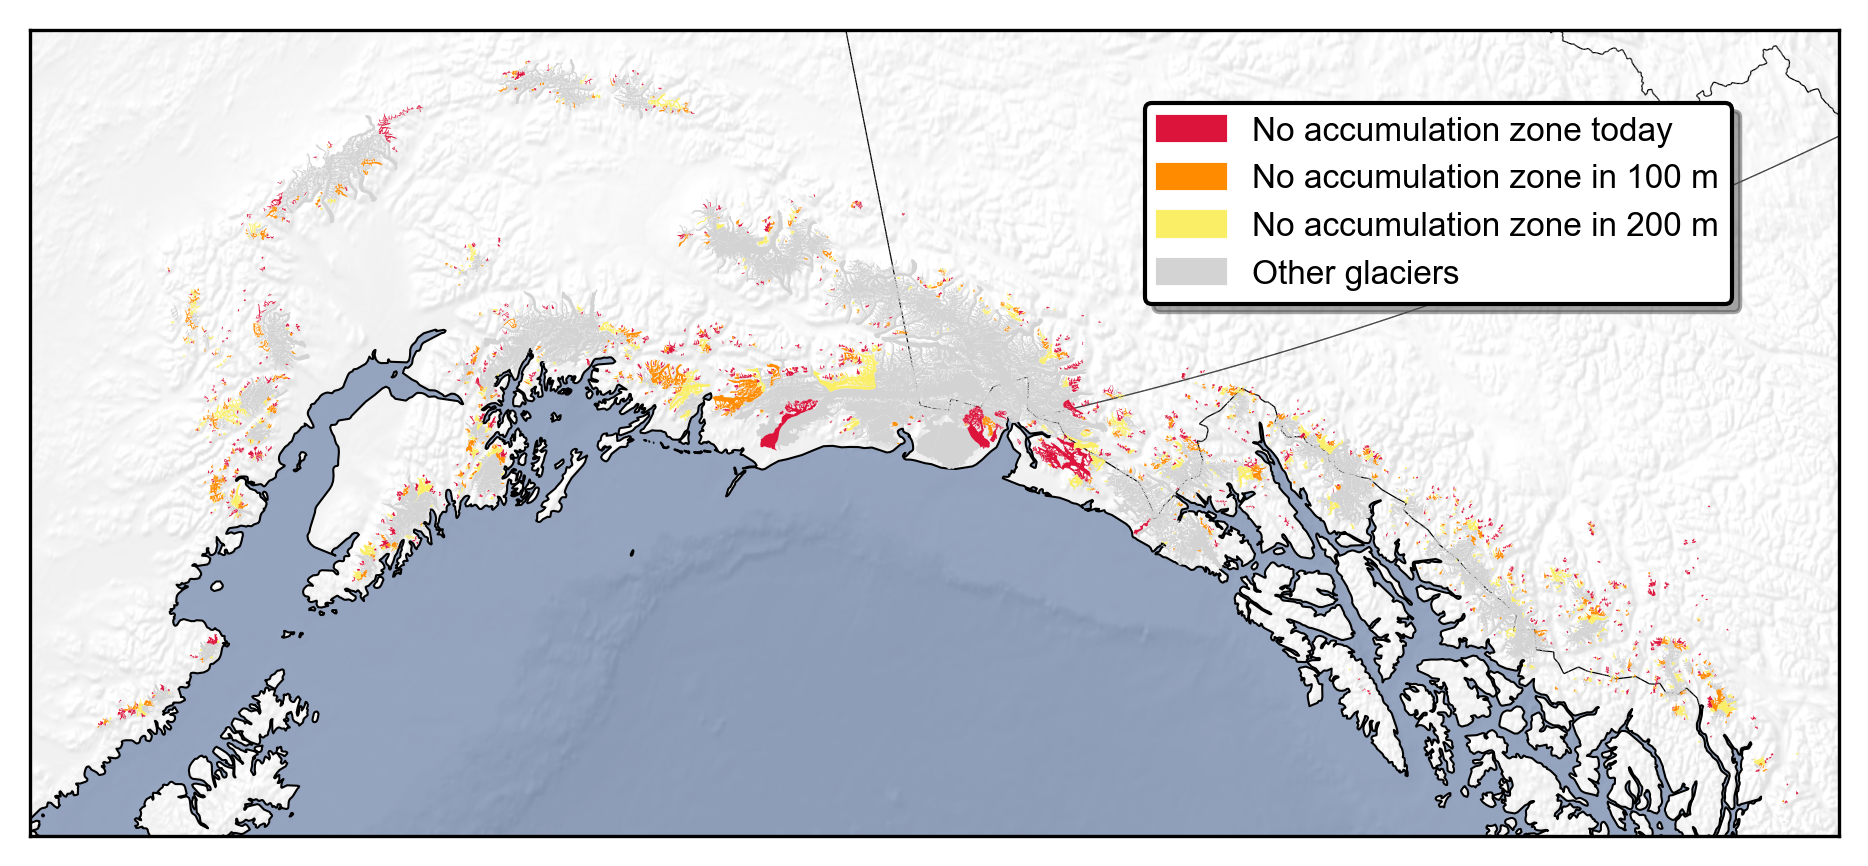

In [6]:
# # start figure
# fig,axs = snowFun.create_base_map(hillshade=1, closeup=True)

# # define colors
# colors = ['lightgrey', "#ff9b35", "#bd370a", "#5e0000"]
# colors = ['lightgrey', "xkcd:yellowish", "darkorange", "crimson"]
# labels = ['Other glaciers', 'No accumulation zone in 200 m', 'No accumulation zone in 100 m', 'No accumulation zone today']
# cmap = ListedColormap(colors)

# # plot dead glaciers
# all_data_gdf.plot(ax=axs, column='dead_color', zorder=2, cmap=cmap, vmin=0, vmax=3) 

# # # create inset axis for legend
# # cb_ax = axs.inset_axes( (0.14,0.55,0.03,0.2), transform=axs.transAxes)

# # manually create legend
# handles = [Patch(color=colors[3], label=labels[3]),
#            Patch(color=colors[2], label=labels[2]),
#            Patch(color=colors[1], label=labels[1]),
#            Patch(color=colors[0], label=labels[0])]

# axs.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.95,0.93),
#            fontsize=8, framealpha=1, edgecolor='black', shadow='True', fancybox='False')

# # edit cbar axis
# # cb_ax.tick_params(labelsize=6, length=3, pad=1)
# # cb_ax.set_xlabel('AAR', size=6, labelpad=3)
# # cb_ax.xaxis.set_label_position('top') 

# # # add background to cbar axis
# # rect = Rectangle((0.09,0.52), 0.1, 0.28, transform=axs.transAxes,
# #                  fc ='white', ec ='black', lw=0.5, zorder=1.1)
# # axs.add_patch(rect)

# # remove map ticks and labels
# axs.set_xticks([])
# axs.set_yticks([])
# axs.set_xlabel("")
# axs.set_ylabel("")

# out_path = os.path.join(folder_AGVA, 'Figures', 'dead glaciers', 'dead_glaciers.png')
# # plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [ ]:
# start figure
fig,axs = snowFun.create_base_map(hillshade=1, closeup=True)

# define colors
colors = ['lightgrey', "darkorange", "maroon"]
labels = ['Other glaciers', 'No accumulation zone in\nend-of-century projections', 'No modern accumulation zone']
cmap = ListedColormap(colors)

# plot dead glaciers
all_data_gdf.plot(ax=axs, column='dead_color', zorder=2, cmap=cmap, vmin=0, vmax=3) 


# manually create legend
handles = [Patch(color=colors[2], label=labels[2]),
           Patch(color=colors[1], label=labels[1]),
           Patch(color=colors[0], label=labels[0])]

axs.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.99,0.97), labelspacing=0.7,
           fontsize=8, framealpha=1, edgecolor='black', shadow='True', fancybox=True)


# remove map ticks and labels
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")

out_path = os.path.join(folder_AGVA, 'Figures', 'dead glaciers', 'dead_glaciers_cmip.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [8]:
# print stats
print("Dead today")
df = all_data_gdf[all_data_gdf['dead_today']==1]
print("n=",len(df))
print("area=",np.nansum(df['Area']))
print()
print("Dead 100")
df = all_data_gdf[all_data_gdf['dead_100']==1]
print("n=",len(df))
print("area=",np.nansum(df['Area']))
print()
print('Dead 200')
df = all_data_gdf[all_data_gdf['dead_200']==1]
print("n=",len(df))
print("area=",np.nansum(df['Area']))
print()
print('Dead CMIP')
df = all_data_gdf[all_data_gdf['dead_cmip']==1]
print("n=",len(df))
print("area=",np.nansum(df['Area']))


Dead today
n= 1009
area= 6465.68

Dead 100
n= 1587
area= 11974.074

Dead 200
n= 2083
area= 18626.621

Dead CMIP
n= 1944
area= 16538.27
